# Prognose des stündlichen Stromverbrauchs in Deutschland mit dem XGBoost Algorithmus

Energie ist nach wie vor ein wertvolles Gut. Da sich Energie kaum wirtschaftlich effizient speichern lässt, bedarf es einer genauen Planung der Produktion. Gerade vor dem Hintergrund der Energiewende gewinnt die Versorgungssicherheit immer mehr an Bedeutung. Im Rahmen dieser Arbeit soll daher der Stromverbrauch prognostiziert werden. Nur durch eine genaue Prognose des Verbrauchs lässt sich die Stromproduktion planen.
Diese Arbeit basiert auf einer bereits bestehenden Implementation von François Raucent. [Das bestehende Modell](https://www.kaggle.com/code/francoisraucent/forecasting-electricity-consumption-of-germany) kann auf "Kaggle.com" gefunden werden.

Neben kleineren Anpassungen und Erweiterungen der Implementation fokussiert sich die Arbeit auf die Anreicherung der Datengrundlage über weitere Einflussfaktoren / Features.

Die Daten des Stromverbrauchs wurden von der Transparenzplattform der Europäischen Übertragungsnetzbetreiber [ENTSO-E Transparency Platform](https://transparency.entsoe.eu/) bezogen.

In [55]:
import pandas as pd
import numpy as np
import math

import holidays

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv

## Laden der Daten

Der untersuchte Zeitraum begrenzt sich zunächst auf Jan 2015 bis Jan 2020.

In [56]:
STUDY_START_DATE = pd.Timestamp("2015-01-01 00:00", tz="utc")
STUDY_END_DATE = pd.Timestamp("2020-01-31 23:00", tz="utc")

#Pandemie-Test
#STUDY_START_DATE = pd.Timestamp("2015-01-01 00:00", tz="utc")
#STUDY_END_DATE = pd.Timestamp("2022-01-31 23:00", tz="utc")

Der Stromverbrauch in der Quelle wird in Megawatt pro Viertelstunde angegeben. Für diese Analyse werden die Daten auf stündliche Auflösung aggregiert. So können die Wert auch als Megawattstunden interpretiert werden.

In [57]:
de_load = pd.read_csv("/content/Datengrundlage_Stromverbrauch_Deutschland.csv", sep=';')
de_load = de_load.set_index("Zeitstempel")
de_load.index = pd.to_datetime(de_load.index)
de_load.index.name = "Zeit"
de_load = de_load.groupby(pd.Grouper(freq="h")).mean()
de_load = de_load.loc[
    (de_load.index >= STUDY_START_DATE) & (de_load.index <= STUDY_END_DATE), :
]
de_load["Stromverbrauch_Deutschland_MWh"] = de_load["Stromverbrauch_Deutschland_MW"]
de_load.insert(0, 'Stromverbrauch_Deutschland_MWh', de_load.pop('Stromverbrauch_Deutschland_MWh'))
del de_load["Stromverbrauch_Deutschland_MW"]

de_load.info()
#print(de_load)
#print(de_load.mean())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44568 entries, 2015-01-01 00:00:00+00:00 to 2020-01-31 23:00:00+00:00
Data columns (total 37 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   Stromverbrauch_Deutschland_MWh                                                                      44568 non-null  float64
 1   load_MW_DE_50Hertz                                                                                  44568 non-null  float64
 2   load_MW_DE_total_TransnetBW                                                                         44568 non-null  float64
 3   load_MW_DE_total_TenneT                                                                             44568 non-null  float64
 4   load_MW_DE_total_Amprion                                         

Die letzten 12 Monate werden als Test-Datensatz verwendet. Das Training des Modell sbeschränkt sich daher auf den Zeitraum Jan. 2015 bis Jan. 2019.

In [58]:
def split_train_test(df, split_time):
    df_train = df.loc[df.index < split_time]
    df_test = df.loc[df.index >= split_time]
    return df_train, df_test

df_train, df_test = split_train_test(
    de_load, pd.Timestamp("2019-02-01", tz="utc")
    
    #Pandemie-Test
    #de_load, pd.Timestamp("2020-02-01", tz="utc")
)

Der Test-Datensatz entspricht ungefähr 20% der Gesamtdaten.


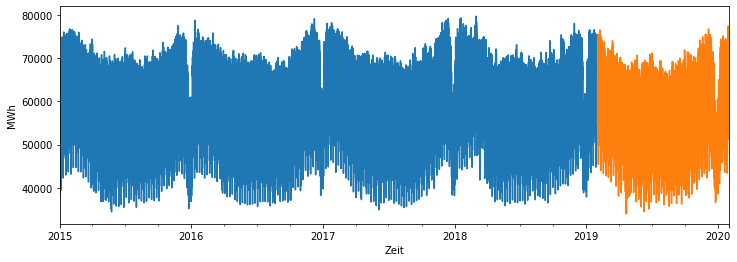

In [59]:
ax = df_train["Stromverbrauch_Deutschland_MWh"].plot(figsize=(12, 4), color="tab:blue")
_ = df_test["Stromverbrauch_Deutschland_MWh"].plot(ax=ax, color="tab:orange", ylabel="MWh")

## Datenaufbereitung

In [60]:
df_train.loc[df_train["Stromverbrauch_Deutschland_MWh"].isna(), :].index

DatetimeIndex([], dtype='datetime64[ns, UTC]', name='Zeit', freq=None)

### Erstellung der Features

In [61]:
def add_time_features(df):
    cet_index = df.index.tz_convert("CET")
    df["Monat"] = cet_index.month
    df["Wochentag"] = cet_index.weekday
    df["Stunde"] = cet_index.hour
    return df

def add_holiday_features(df):
    de_holidays = holidays.Germany()
    cet_dates = pd.Series(df.index.tz_convert("CET"), index=df.index)
    df["Feiertag"] = cet_dates.apply(lambda d: d in de_holidays)
    df["Feiertag"] = df["Feiertag"].astype(int)
    return df

def add_regional_holiday_features(df):
    de_regions = holidays.Germany().PROVINCES
    for region in de_regions:
      de_regional_holidays = holidays.Germany()
      de_regional_holidays.prov = region
      cet_dates = pd.Series(df.index.tz_convert("CET"), index=df.index)
      df["Feiertag_"+region] = cet_dates.apply(lambda d: d in de_regional_holidays)
      df["Feiertag_"+region] = df["Feiertag_"+region].astype(int)
    return df

def add_holiday_lag_features(df):
    holiday_cols = ["Feiertag", "Halber_Feiertag", "Feiertag_BW", "Feiertag_BY", "Feiertag_BE", "Feiertag_BB", "Feiertag_HB", "Feiertag_HH", "Feiertag_HE", "Feiertag_MV", "Feiertag_NI", "Feiertag_NW", "Feiertag_RP", "Feiertag_SL", "Feiertag_SN", "Feiertag_ST", "Feiertag_SH", "Feiertag_TH"]
    #Auswahl welche Lag-Features für Feiertage erstellt werden sollen. Ab Iterationsschritt 6 ist die zweite Zeile zu verwenden.
    #list_of_hours = [24,48,-24,-48]
    list_of_hours = [24,-24]

    for holiday_feature in holiday_cols:
      for n_hours in list_of_hours:
        shifted_col = df[holiday_feature].shift(n_hours, "h")
        shifted_col = shifted_col.loc[df.index.min(): df.index.max()]
        label = f"{holiday_feature}_lag_{n_hours}h"
        df[label] = np.nan
        df.loc[shifted_col.index, label] = shifted_col
    return df

def add_lag_features(df, col="Stromverbrauch_Deutschland_MWh"):
    list_of_hours = list(range(24, 49))
    #Add Lag-Feature-1WEEK
    list_of_hours.append(168)

    for n_hours in list_of_hours:
        shifted_col = df[col].shift(n_hours, "h")
        shifted_col = shifted_col.loc[df.index.min(): df.index.max()]
        label = f"{col}_lag_{n_hours}h"
        df[label] = np.nan
        df.loc[shifted_col.index, label] = shifted_col
    return df

def add_all_features(df, target_col="Stromverbrauch_Deutschland_MWh"):
    df = df.copy()
    df = add_time_features(df)
    df = add_holiday_features(df)
    df = add_regional_holiday_features(df)
    df = add_lag_features(df, col=target_col)
    df = add_holiday_lag_features(df)
    return df


Durch die Lag-Features entstehen einige Lücken in den Daten. Fortan beschränkt sich das Modell auf die vollständigen Beobachtungen.

In [62]:
df_train.info()
df_train = add_all_features(df_train).dropna()
df_test = add_all_features(df_test).dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35808 entries, 2015-01-01 00:00:00+00:00 to 2019-01-31 23:00:00+00:00
Data columns (total 37 columns):
 #   Column                                                                                              Non-Null Count  Dtype  
---  ------                                                                                              --------------  -----  
 0   Stromverbrauch_Deutschland_MWh                                                                      35808 non-null  float64
 1   load_MW_DE_50Hertz                                                                                  35808 non-null  float64
 2   load_MW_DE_total_TransnetBW                                                                         35808 non-null  float64
 3   load_MW_DE_total_TenneT                                                                             35808 non-null  float64
 4   load_MW_DE_total_Amprion                                         

In [63]:
target_col = "Stromverbrauch_Deutschland_MWh"
X_train = df_train.drop(columns=target_col)
y_train = df_train.loc[:, target_col]
X_test = df_test.drop(columns=target_col)
y_test = df_test.loc[:, target_col]

### Data preparation pipeline

In diesem Schritt werden kategoriale Features in Dummy-Variablen aufgeteilt. Dies ist notwendig, damit diese in der Regression verwendet werden können.

In [64]:
def fit_prep_pipeline(df):
    cat_features = ["Monat", "Wochentag", "Stunde"]  # categorical features
    bool_features = ["Feiertag"]  # boolean features
    num_features = [c for c in df.columns
                    if c.startswith("Stromverbrauch_Deutschland_MWh_lag")]  # numerical features

    #Zeitumstellung
    bool_features.append("Sommerzeit");

    #regionale Ferien
    bool_features.extend(["Ferien_BW", "Ferien_BY", "Ferien_BE", "Ferien_BB", "Ferien_HB", "Ferien_HH", "Ferien_HE", "Ferien_MV", "Ferien_NI", "Ferien_NW", "Ferien_RP", "Ferien_SL", "Ferien_SN", "Ferien_ST", "Ferien_SH", "Ferien_TH"])

    #regionale Feiertage
    bool_features.extend(["Feiertag_BW", "Feiertag_BY", "Feiertag_BE", "Feiertag_BB", "Feiertag_HB", "Feiertag_HH", "Feiertag_HE", "Feiertag_MV", "Feiertag_NI", "Feiertag_NW", "Feiertag_RP", "Feiertag_SL", "Feiertag_SN", "Feiertag_ST", "Feiertag_SH", "Feiertag_TH"])
    
    #halbe Feiertage (Heiligabend & Silvester)
    bool_features.append("Halber_Feiertag")

    #Lag-features für Feiertage
    #Ab Iterationsschritt 6 ist die unterste Zeile dieses Blocks zu verwenden.
    #24h & 48h
    #bool_features.extend(['Feiertag_lag_24h', 'Feiertag_lag_48h', 'Feiertag_lag_-24h', 'Feiertag_lag_-48h', 'Halber_Feiertag_lag_24h', 'Halber_Feiertag_lag_48h', 'Halber_Feiertag_lag_-24h', 'Halber_Feiertag_lag_-48h', 'Feiertag_BW_lag_24h', 'Feiertag_BW_lag_48h', 'Feiertag_BW_lag_-24h', 'Feiertag_BW_lag_-48h', 'Feiertag_BY_lag_24h', 'Feiertag_BY_lag_48h', 'Feiertag_BY_lag_-24h', 'Feiertag_BY_lag_-48h', 'Feiertag_BE_lag_24h', 'Feiertag_BE_lag_48h', 'Feiertag_BE_lag_-24h', 'Feiertag_BE_lag_-48h', 'Feiertag_BB_lag_24h', 'Feiertag_BB_lag_48h', 'Feiertag_BB_lag_-24h', 'Feiertag_BB_lag_-48h', 'Feiertag_HB_lag_24h', 'Feiertag_HB_lag_48h', 'Feiertag_HB_lag_-24h', 'Feiertag_HB_lag_-48h', 'Feiertag_HH_lag_24h', 'Feiertag_HH_lag_48h', 'Feiertag_HH_lag_-24h', 'Feiertag_HH_lag_-48h', 'Feiertag_HE_lag_24h', 'Feiertag_HE_lag_48h', 'Feiertag_HE_lag_-24h', 'Feiertag_HE_lag_-48h', 'Feiertag_MV_lag_24h', 'Feiertag_MV_lag_48h', 'Feiertag_MV_lag_-24h', 'Feiertag_MV_lag_-48h', 'Feiertag_NI_lag_24h', 'Feiertag_NI_lag_48h', 'Feiertag_NI_lag_-24h', 'Feiertag_NI_lag_-48h', 'Feiertag_NW_lag_24h', 'Feiertag_NW_lag_48h', 'Feiertag_NW_lag_-24h', 'Feiertag_NW_lag_-48h', 'Feiertag_RP_lag_24h', 'Feiertag_RP_lag_48h', 'Feiertag_RP_lag_-24h', 'Feiertag_RP_lag_-48h', 'Feiertag_SL_lag_24h', 'Feiertag_SL_lag_48h', 'Feiertag_SL_lag_-24h', 'Feiertag_SL_lag_-48h', 'Feiertag_SN_lag_24h', 'Feiertag_SN_lag_48h', 'Feiertag_SN_lag_-24h', 'Feiertag_SN_lag_-48h', 'Feiertag_ST_lag_24h', 'Feiertag_ST_lag_48h', 'Feiertag_ST_lag_-24h', 'Feiertag_ST_lag_-48h', 'Feiertag_SH_lag_24h', 'Feiertag_SH_lag_48h', 'Feiertag_SH_lag_-24h', 'Feiertag_SH_lag_-48h', 'Feiertag_TH_lag_24h', 'Feiertag_TH_lag_48h', 'Feiertag_TH_lag_-24h', 'Feiertag_TH_lag_-48h'])
    #nur 24h
    bool_features.extend(['Feiertag_lag_24h', 'Feiertag_lag_-24h', 'Halber_Feiertag_lag_24h', 'Halber_Feiertag_lag_-24h', 'Feiertag_BW_lag_24h', 'Feiertag_BW_lag_-24h', 'Feiertag_BY_lag_24h', 'Feiertag_BY_lag_-24h', 'Feiertag_BE_lag_24h', 'Feiertag_BE_lag_-24h', 'Feiertag_BB_lag_24h', 'Feiertag_BB_lag_-24h', 'Feiertag_HB_lag_24h', 'Feiertag_HB_lag_-24h', 'Feiertag_HH_lag_24h', 'Feiertag_HH_lag_-24h', 'Feiertag_HE_lag_24h', 'Feiertag_HE_lag_-24h', 'Feiertag_MV_lag_24h', 'Feiertag_MV_lag_-24h', 'Feiertag_NI_lag_24h', 'Feiertag_NI_lag_-24h', 'Feiertag_NW_lag_24h', 'Feiertag_NW_lag_-24h', 'Feiertag_RP_lag_24h', 'Feiertag_RP_lag_-24h', 'Feiertag_SL_lag_24h', 'Feiertag_SL_lag_-24h', 'Feiertag_SN_lag_24h', 'Feiertag_SN_lag_-24h', 'Feiertag_ST_lag_24h', 'Feiertag_ST_lag_-24h', 'Feiertag_SH_lag_24h', 'Feiertag_SH_lag_-24h', 'Feiertag_TH_lag_24h', 'Feiertag_TH_lag_-24h'])
    
    #klimatische Einflüsse
    num_features.append("Stuttgart_Lufttemperatur_Grad_Celcius_Wetterstation_4931");
    num_features.append("Stuttgart_Absolute_Luftfeuchtigkeit_Gramm_Pro_Kubikmeter_Wetterstation_4931");
    num_features.append("Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931");
    num_features.append("Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931");
    num_features.append("Stuttgart_Windgeschwindigkeit_Meter_Pro_Sekunde_Wetterstation_4931");
    num_features.append("Stuttgart_Stundensumme_Kurzwelligen_Globalstrahlung_Joule_Pro_Quadratzentimeter_Wetterstation_4928");
    num_features.append("Stuttgart_Stundensumme_Sonnenscheindauer_Minuten_Wetterstation_4928");

    #Strompreis
    num_features.append("Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh");
    bool_features.append("Dummy_Engpassbewirtschaftung_Strompreisgebotszonen");

    #DAX-Kurs
    num_features.append("DAX_Hochpunkt");
    num_features.append("DAX_Tiefpunkt");
    num_features.append("DAX_Eroeffnungskurs");
    num_features.append("DAX_Schlusskurs");
    num_features.append("DAX_Volumen");

    prep_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("bool", FunctionTransformer(), bool_features),
        ("num", StandardScaler(), num_features),
    ])
    prep_pipeline = prep_pipeline.fit(df)
    
    feature_names = []
    one_hot_tf = prep_pipeline.transformers_[0][1]
    for i, cat_feature in enumerate(cat_features):
        categories = one_hot_tf.categories_[i]
        cat_names = [f"{cat_feature}_{c}" for c in categories]
        feature_names += cat_names
    feature_names += (bool_features + num_features)
    
    return feature_names, prep_pipeline



Anwendung der Data preparation pipeline auf die Traings- und Test-Daten.

In [65]:
feature_names, prep_pipeline = fit_prep_pipeline(X_train)

X_train_prep = prep_pipeline.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=df_train.index)
X_test_prep = prep_pipeline.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names, index=df_test.index)

X_train_prep.info()
X_train_prep.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35615 entries, 2015-01-08 00:00:00+00:00 to 2019-01-30 23:00:00+00:00
Columns: 154 entries, Monat_1 to DAX_Volumen
dtypes: float64(154)
memory usage: 42.1 MB


Index(['Monat_1', 'Monat_2', 'Monat_3', 'Monat_4', 'Monat_5', 'Monat_6',
       'Monat_7', 'Monat_8', 'Monat_9', 'Monat_10',
       ...
       'Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931',
       'Stuttgart_Windgeschwindigkeit_Meter_Pro_Sekunde_Wetterstation_4931',
       'Stuttgart_Stundensumme_Kurzwelligen_Globalstrahlung_Joule_Pro_Quadratzentimeter_Wetterstation_4928',
       'Stuttgart_Stundensumme_Sonnenscheindauer_Minuten_Wetterstation_4928',
       'Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh', 'DAX_Hochpunkt',
       'DAX_Tiefpunkt', 'DAX_Eroeffnungskurs', 'DAX_Schlusskurs',
       'DAX_Volumen'],
      dtype='object', length=154)

Die folgenden Zellen umfassen die einzelnen Iterationsschritte. Hierbei ist immer nur eine Zelle auszuführen. Der letzte Iterationsschritt umfasst alle vorherigen.

In [ ]:
#1. Iterationsschritt: Alle potentiellen Features
#keine Anpassung notwendig

In [ ]:
#2. Iterationsschritt: Ohne Strompreis und Dummy für die Engpasswirtschaft
#X_train_prep.drop(["Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
#X_test_prep.drop(["Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [ ]:
#3. Iterationsschritt: Ohne Strompreis, Dummy für die Engpasswirtschaft und DAX-Features
#X_train_prep.drop(["DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
#X_test_prep.drop(["DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [ ]:
#4. Iterationsschritt: Ohne Strompreis, Dummy für die Engpasswirtschaft, DAX-Features und relative Luftfeuchtigkeit
#X_train_prep.drop(["Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
#X_test_prep.drop(["Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [ ]:
#5. Iterationsschritt: Ohne Strompreis, Dummy für die Engpasswirtschaft, DAX-Features, relative Luftfeuchtigkeit und Luftdruck
#X_train_prep.drop(["Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
#X_test_prep.drop(["Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [ ]:
#6. Iterationsschritt: Ohne Strompreis, Dummy für die Engpasswirtschaft, DAX-Features, relative Luftfeuchtigkeit, Luftdruck und 48h-Lag-Features für Feiertage
#Weitere Anpassungen sind notwendig, damit die 48h-Lag-Features für die Feiertage niemals erstellt werden (s.o. Kommentare).
#X_train_prep.drop(["Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
#X_test_prep.drop(["Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [66]:
#7. Iterationsschritt: Ohne Strompreis, Dummy für die Engpasswirtschaft, DAX-Features, relative Luftfeuchtigkeit, Luftdruck, 48h-Lag-Features für Feiertage und Features mit Shapley-Wert = 0
#Weitere Anpassungen sind notwendig, damit die 48h-Lag-Features für die Feiertage niemals erstellt werden (s.o. Kommentare).
X_train_prep.drop(["Feiertag_RP", "Stunde_15", "Feiertag_BE", "Feiertag_HH", "Feiertag_NI", "Stunde_14", "Feiertag_SH", "Feiertag_SH_lag_24h", "Feiertag_TH", "Feiertag_BE_lag_24h", "Feiertag_HH_lag_24h", "Feiertag_HH_lag_-24h", "Feiertag_MV_lag_-24h", "Feiertag_NI_lag_24h", "Feiertag_NI_lag_-24h", "Feiertag_RP_lag_24h", "Feiertag_RP_lag_-24h", "Feiertag_SN_lag_-24h", "Feiertag_TH_lag_-24h", "Feiertag_TH_lag_24h", "Feiertag_SH_lag_-24h", "Feiertag_BE_lag_-24h", "Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)
X_test_prep.drop(["Feiertag_RP", "Stunde_15", "Feiertag_BE", "Feiertag_HH", "Feiertag_NI", "Stunde_14", "Feiertag_SH", "Feiertag_SH_lag_24h", "Feiertag_TH", "Feiertag_BE_lag_24h", "Feiertag_HH_lag_24h", "Feiertag_HH_lag_-24h", "Feiertag_MV_lag_-24h", "Feiertag_NI_lag_24h", "Feiertag_NI_lag_-24h", "Feiertag_RP_lag_24h", "Feiertag_RP_lag_-24h", "Feiertag_SN_lag_-24h", "Feiertag_TH_lag_-24h", "Feiertag_TH_lag_24h", "Feiertag_SH_lag_-24h", "Feiertag_BE_lag_-24h", "Stuttgart_Luftdruck_Hektopascal_Wetterstation_4931", "Stuttgart_Relative_Luftfeuchtigkeit_Prozent_Wetterstation_4931", "DAX_Hochpunkt", "DAX_Tiefpunkt", "DAX_Eroeffnungskurs", "DAX_Schlusskurs", "DAX_Volumen", "Strompreis_Gebotszone_mit_Deutschland_Euro_pro_MWh", "Dummy_Engpassbewirtschaftung_Strompreisgebotszonen"], axis=1, inplace=True)

In [67]:
#Auflistung der verwendeten Features
for i in list(X_train_prep.columns):
  print(i)

Monat_1
Monat_2
Monat_3
Monat_4
Monat_5
Monat_6
Monat_7
Monat_8
Monat_9
Monat_10
Monat_11
Monat_12
Wochentag_0
Wochentag_1
Wochentag_2
Wochentag_3
Wochentag_4
Wochentag_5
Wochentag_6
Stunde_0
Stunde_1
Stunde_2
Stunde_3
Stunde_4
Stunde_5
Stunde_6
Stunde_7
Stunde_8
Stunde_9
Stunde_10
Stunde_11
Stunde_12
Stunde_13
Stunde_16
Stunde_17
Stunde_18
Stunde_19
Stunde_20
Stunde_21
Stunde_22
Stunde_23
Feiertag
Sommerzeit
Ferien_BW
Ferien_BY
Ferien_BE
Ferien_BB
Ferien_HB
Ferien_HH
Ferien_HE
Ferien_MV
Ferien_NI
Ferien_NW
Ferien_RP
Ferien_SL
Ferien_SN
Ferien_ST
Ferien_SH
Ferien_TH
Feiertag_BW
Feiertag_BY
Feiertag_BB
Feiertag_HB
Feiertag_HE
Feiertag_MV
Feiertag_NW
Feiertag_SL
Feiertag_SN
Feiertag_ST
Halber_Feiertag
Feiertag_lag_24h
Feiertag_lag_-24h
Halber_Feiertag_lag_24h
Halber_Feiertag_lag_-24h
Feiertag_BW_lag_24h
Feiertag_BW_lag_-24h
Feiertag_BY_lag_24h
Feiertag_BY_lag_-24h
Feiertag_BB_lag_24h
Feiertag_BB_lag_-24h
Feiertag_HB_lag_24h
Feiertag_HB_lag_-24h
Feiertag_HE_lag_24h
Feiertag_HE_lag_-24h
Fe

## Training des Regressionsmodells

In [68]:
xgb_model = XGBRegressor(n_estimators=1000)

### Einfluss der Features

#### Anzahl der Vergleiche im Entscheidungsbaum pro Feature

Es folgt die Analyse der Wichtigkeit einzelner Features anhand der Anzahl an Vergleichen im Entscheidungsbaum pro Feature.

[10:45:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


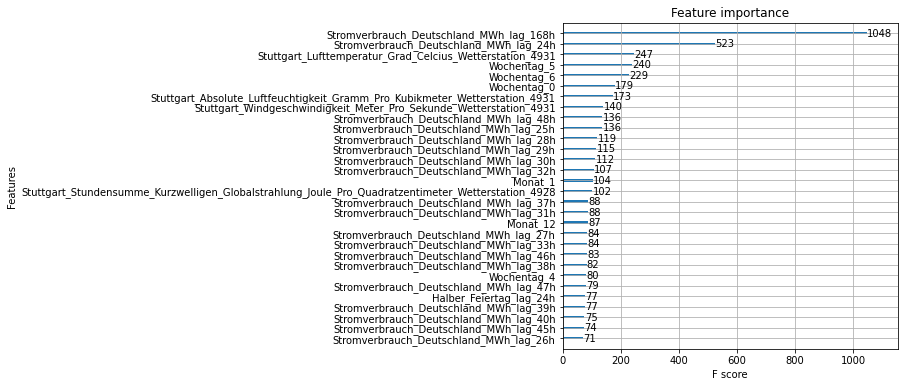

In [69]:
xgb_model.fit(X_train_prep, y=y_train)
_, ax = plt.subplots(1, 1, figsize=(6, 6))
_ = plot_importance(xgb_model, ax=ax, max_num_features=30)

#### Shapley-Werte


In [70]:
!pip install shap
import shap 

     |████████████████████████████████| 564 kB 7.4 MB/s 


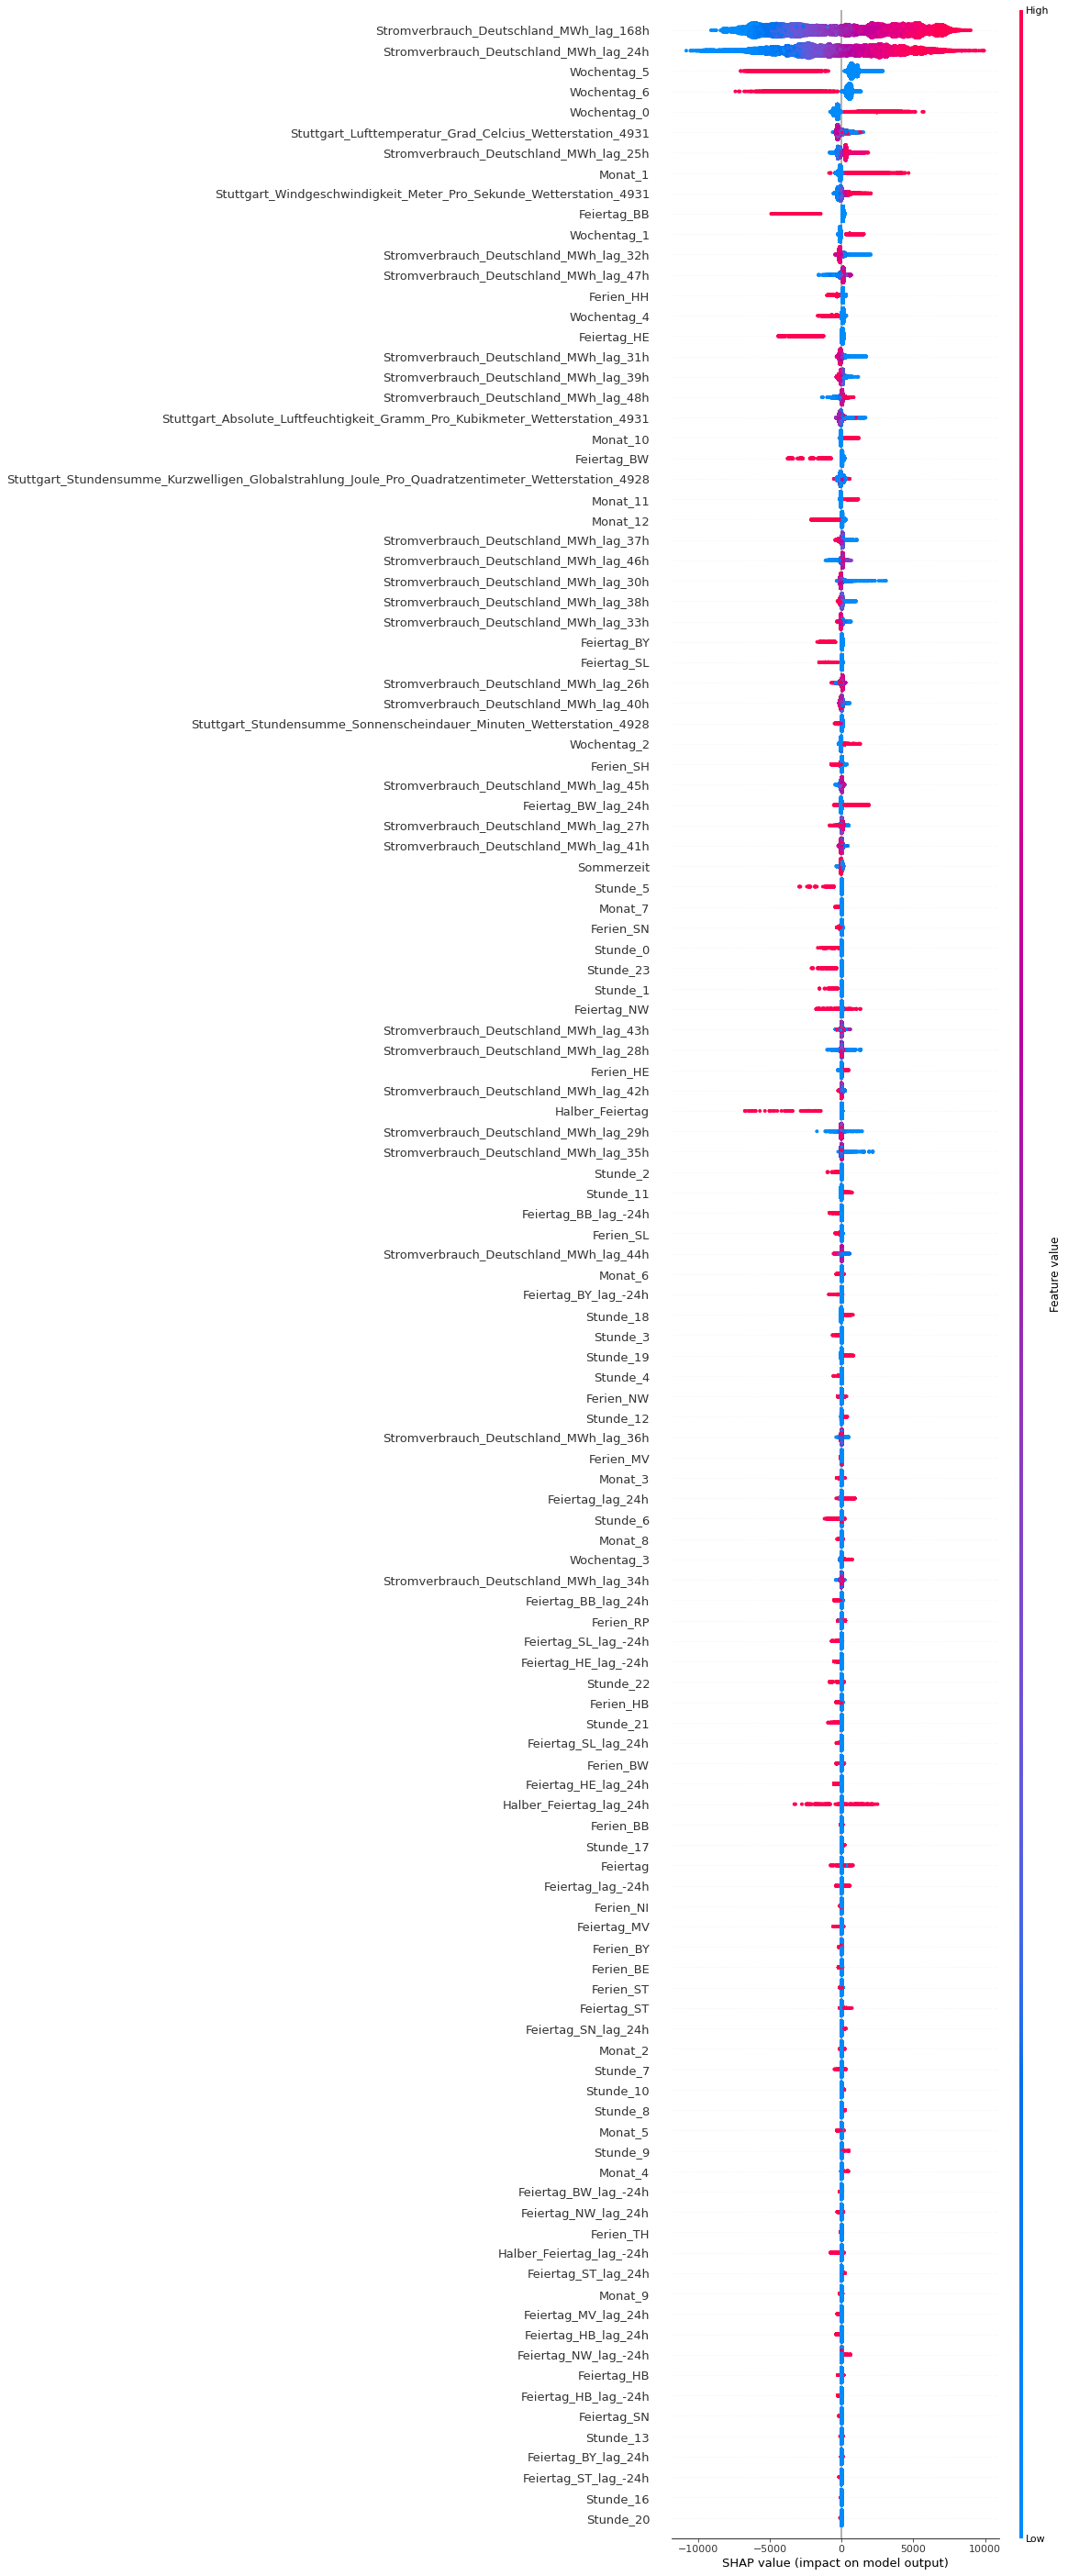

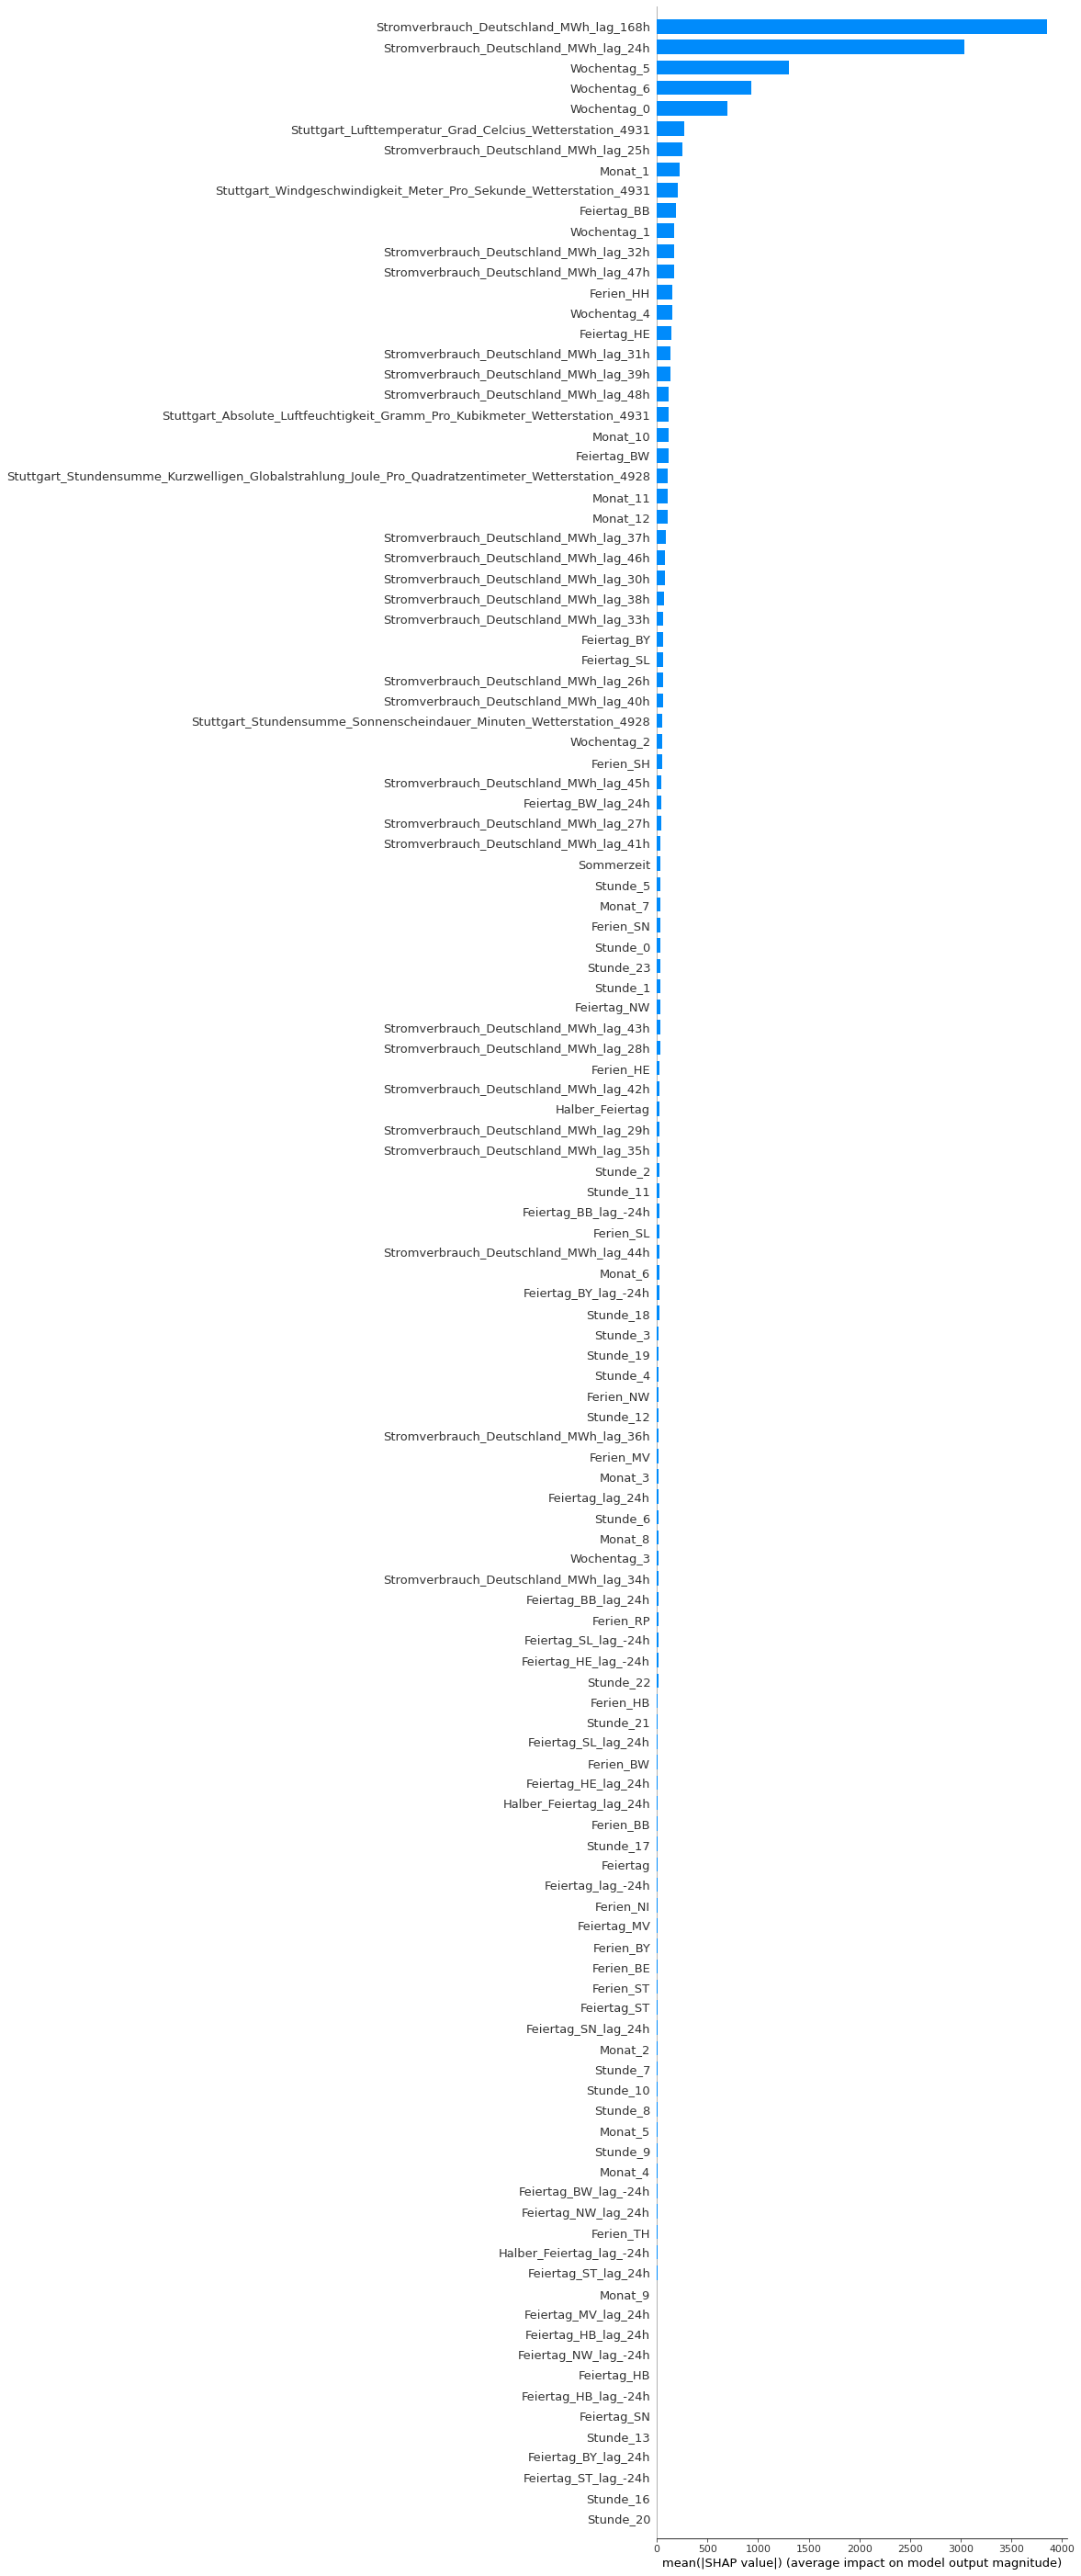

In [71]:
explainer = shap.TreeExplainer(xgb_model)
shap.initjs()

Xr = X_train_prep
Yr = y_train

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_prep.iloc[1:100000,:], y_train[1:100000].values)
shap.summary_plot(shap_values, Xr[1:100000], max_display=Xr.shape[1])
shap.summary_plot(shap_values, Xr[1:100000], max_display=Xr.shape[1], plot_type="bar")

In [72]:
vals= np.abs(shap_values).mean(0)
#vals= np.abs(shap_values).max(0)
feature_importance = pd.DataFrame(list(zip(Xr.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(feature_importance)

                                              col_name  \
117            Stromverbrauch_Deutschland_MWh_lag_168h   
92              Stromverbrauch_Deutschland_MWh_lag_24h   
17                                         Wochentag_5   
18                                         Wochentag_6   
12                                         Wochentag_0   
118  Stuttgart_Lufttemperatur_Grad_Celcius_Wetterst...   
93              Stromverbrauch_Deutschland_MWh_lag_25h   
0                                              Monat_1   
120  Stuttgart_Windgeschwindigkeit_Meter_Pro_Sekund...   
61                                         Feiertag_BB   
13                                         Wochentag_1   
100             Stromverbrauch_Deutschland_MWh_lag_32h   
115             Stromverbrauch_Deutschland_MWh_lag_47h   
48                                           Ferien_HH   
16                                         Wochentag_4   
63                                         Feiertag_HE   
99            

## Optimierung des Modells

An dieser Stelle werden die Hyperparameter des XGBoost Algorithmus optimiert. Hierzu wird eine 4-Fold Kreuzvalidierung durchgeführt.

### Kreuzvalidierung

Die folgende Funktion setzt eine Rastersuche (cross-validation) mit Kreuzvalidierungen für XGBoost Modelle um.

In [ ]:
def xgb_grid_search_cv(
    params_grid, X, y, nfold,
    num_boost_round=1000, early_stopping_rounds=10,
):
    params_grid = ParameterGrid(params_grid)
    search_results = []
    print(f"Grid search CV : nfold={nfold}, " +
          f"numb_boost_round={num_boost_round}, " +
          f"early_stopping_round={early_stopping_rounds}")
    for params in params_grid:
        print(f"\t{params}")
        cv_df = xgb_cv(
            params=params, dtrain=DMatrix(X, y), nfold=nfold,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            shuffle=False, metrics={"rmse"},
        )
        cv_results = params.copy()
        cv_results["train-rmse-mean"] = cv_df["train-rmse-mean"].min()
        cv_results["test-rmse-mean"] = cv_df["test-rmse-mean"].min()
        search_results.append(cv_results)
    return pd.DataFrame(search_results)
    

Der folgende Code führt eine 4-Fold Kreuzvalidierung mit 18 verschiedenen Kombinationen von Hyperparametern durch. Insgesamt werden also 72 Modelle trainiert. Die Rastersuche hat eine Laufzeit von über zwei Stunden. In den folgenden Zellen wird das beste Ergebnis verwendet.

In [ ]:
params_grid = dict(
    eta = [0.08, 0.09, 0.1, 0.11],
    max_depth = [4, 5, 6],
    min_child_weight = [1, 2, 3, 4, 5, 6]
)
xgb_search_scores = xgb_grid_search_cv(
    params_grid, X_train_prep, y_train, nfold=4, early_stopping_rounds=10
)

Die Ergebnisse der Kreuzvalidierung sehen wie folgt aus:

In [ ]:
xgb_search_scores.sort_values(by="test-rmse-mean")

### Training des optimierten Modells nach der Kreuzvalidierung


In [40]:
final_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.09, max_depth=5, min_child_weight=6
)
final_model.fit(
    X_train_prep, y_train, early_stopping_rounds=10,
    eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)],
    verbose=False,
)

[10:32:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.09, max_depth=5, min_child_weight=6,
             n_estimators=1000)

## Prognose auf dem Test-Datensatz

Das finale Modell erreicht einen durschnittlichen Prognosefehler (RMSE) von 1432,92 MWh auf dem Test-Datensatz. Mit dem Modell lässt sich 97,87% der Varianz erklären (R-Quadrat).

In [41]:
final_model.best_score

1432.918213

In [42]:
final_model.score(X_test_prep, y_test)

0.9786846164220485

Nun werden die realen Werte und unsere Prognose zusammengeführt.

In [46]:
def compute_predictions_df(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame(dict(actual=y, prediction=y_pred), index=X.index)
    df["squared_error"] =  (df["actual"] - df["prediction"])**2
    return df

pred_df = compute_predictions_df(
    final_model, X_test_prep, y_test
)
pred_df.head()

,actual,prediction,squared_error
Zeit,,,
2019-02-08 00:00:00+00:00,54164.50,53077.957031,1.180576e+06
2019-02-08 01:00:00+00:00,53309.00,52756.175781,3.056146e+05
2019-02-08 02:00:00+00:00,53393.25,53240.167969,2.343411e+04
2019-02-08 03:00:00+00:00,54527.50,54529.539062,4.157776e+00
2019-02-08 04:00:00+00:00,57961.00,57692.964844,7.184284e+04


Vergleich der realen Werte und der Prognose:

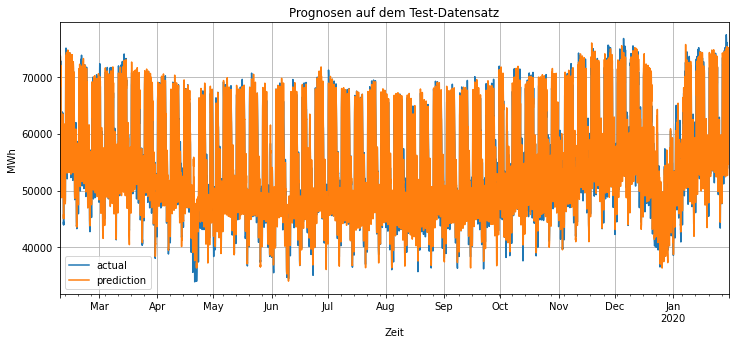

In [47]:
def plot_predictions(pred_df, start=None, end=None):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    start = start or pred_df.index.min()
    end = end or pred_df.index.max()
    pred_df.loc[
        (pred_df.index >= start) & (pred_df.index <= end),
        ["actual", "prediction"]
    ].plot.line(ax=ax)
    ax.set_title("Prognosen auf dem Test-Datensatz")
    ax.set_ylabel("MWh")
    ax.grid()

plot_predictions(pred_df)

### Spezielle Zeiträume

Die Zeiträume
* 18. April 2019 – 25. April 2019 und
* 19. Dezember 2019 – 6. Januar 2020

scheinen sehr interessante Zeiträume für die Analyse zu sein. Es handelt sich um die Oster- und Weihnachtsfeiertage. Die Prognosen in diesen Zeiträumen weisen größere Abweichungen auf.

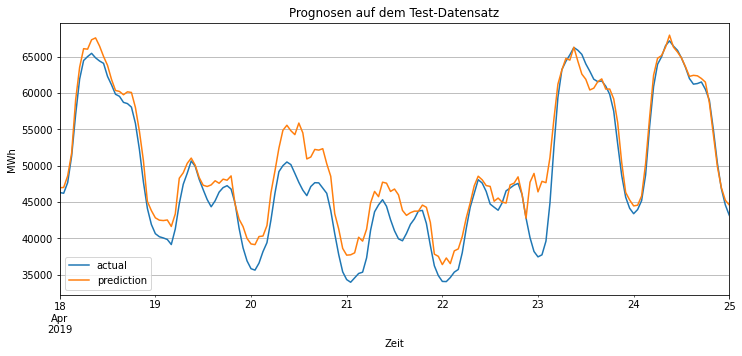

In [48]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-04-18", tz="utc"),
                 end=pd.Timestamp("2019-04-25", tz="utc"))

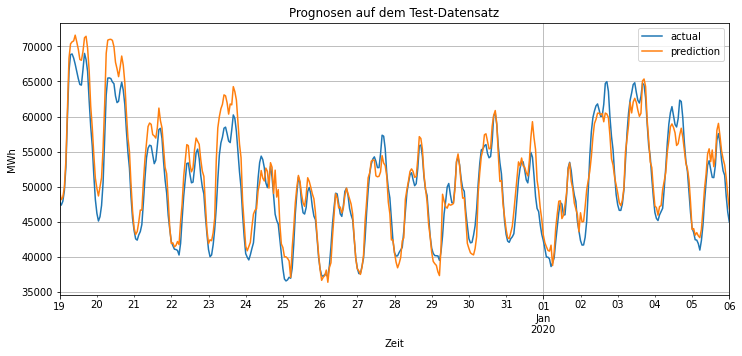

In [49]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-12-19", tz="utc"),
                 end=pd.Timestamp("2020-01-06", tz="utc"))

### Tage mit den besten und schlechtesten Prognosen


Die Tage mit den schlechtesten Prognosen sind die folgenden Tage:

In [52]:
daily_pred_df = pred_df.groupby(pd.Grouper(freq="D")).mean()
daily_pred_df["root_of_squared_error"] = np.sqrt(daily_pred_df["squared_error"])
daily_pred_df.sort_values(by="squared_error", ascending=False).head(10)

,actual,prediction,squared_error,root_of_squared_error
Zeit,,,,
2019-04-20 00:00:00+00:00,44008.666667,48300.359375,2.047459e+07,4524.885633
2019-12-20 00:00:00+00:00,57574.052083,61553.371094,1.762128e+07,4197.771168
2019-12-23 00:00:00+00:00,51731.562500,55608.523438,1.761105e+07,4196.551788
2019-04-23 00:00:00+00:00,55978.843750,57537.246094,1.436467e+07,3790.075753
2019-04-21 00:00:00+00:00,39902.395833,42923.718750,1.137454e+07,3372.616147
2020-01-13 00:00:00+00:00,64063.041667,62076.425781,9.979075e+06,3158.967388
2019-04-22 00:00:00+00:00,42445.750000,44263.753906,9.693262e+06,3113.400471
2019-11-30 00:00:00+00:00,53082.041667,55994.335938,8.845249e+06,2974.096395
2019-05-01 00:00:00+00:00,44686.708333,46884.152344,8.289363e+06,2879.125342


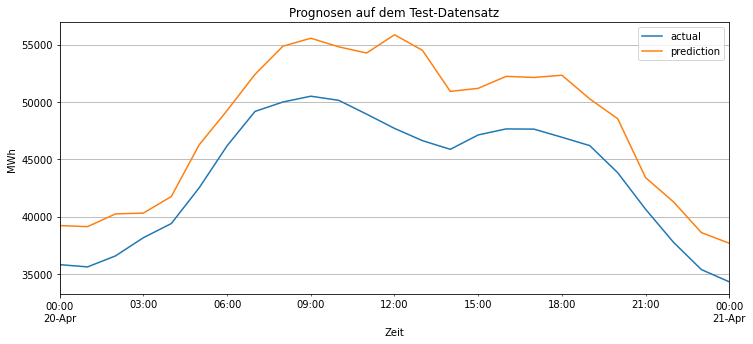

In [53]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-04-20", tz="utc"),
                 end=pd.Timestamp("2019-04-21", tz="utc"))

Die Tage mit den besten Prognosen sind die folgenden Tage:

In [54]:
daily_pred_df.sort_values(by="squared_error", ascending=True).head(10)

,actual,prediction,squared_error,root_of_squared_error
Zeit,,,,
2019-09-10 00:00:00+00:00,57833.197917,57661.835938,139576.786037,373.599767
2019-07-12 00:00:00+00:00,56715.635417,56802.027344,159087.329020,398.857530
2019-06-26 00:00:00+00:00,60699.343750,60689.761719,170340.848838,412.723696
2019-04-09 00:00:00+00:00,60135.083333,60115.839844,173687.421522,416.758229
2020-01-24 00:00:00+00:00,64987.458333,65048.191406,198299.615781,445.308450
2019-07-15 00:00:00+00:00,56174.958333,56077.671875,202222.368140,449.691414
2019-07-23 00:00:00+00:00,57986.468750,57720.507812,222823.383987,472.041718
2019-09-21 00:00:00+00:00,47504.000000,47764.433594,236644.004290,486.460691
2019-03-15 00:00:00+00:00,63440.885417,63122.394531,242416.881165,492.358488
